# Data Science Unit 2 Sprint Challenge 3

## Logistic Regression and Beyond

In this sprint challenge you will fit a logistic regression modeling the probability of an adult having an income above 50K. The dataset is available at UCI:

https://archive.ics.uci.edu/ml/datasets/adult

Your goal is to:

1. Load, validate, and clean/prepare the data.
2. Fit a logistic regression model
3. Answer questions based on the results (as well as a few extra questions about the other modules)

Don't let the perfect be the enemy of the good! Manage your time, and make sure to get to all parts. If you get stuck wrestling with the data, simplify it (if necessary, drop features or rows) so you're able to move on. If you have time at the end, you can go back and try to fix/improve.

### Hints

It has a variety of features - some are continuous, but many are categorical. You may find [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) (a method to one-hot encode) helpful!

The features have dramatically different ranges. You may find [sklearn.preprocessing.minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale) helpful!

In [1]:
from sklearn import metrics, model_selection, linear_model, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Part 1 - Load, validate, and prepare data

The data is available at: https://archive.ics.uci.edu/ml/datasets/adult

Load it, name the columns, and make sure that you've loaded the data successfully. Note that missing values for categorical variables can essentially be considered another category ("unknown"), and may not need to be dropped.

You should also prepare the data for logistic regression - one-hot encode categorical features as appropriate.

In [186]:
names = """
age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
"""

names, description = np.array(list(map(lambda s: s.replace('-', '_').split(':'), names.split('\n')))[1:-1]).T
names

array(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'],
      dtype='<U416')

In [197]:
raw_census = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None)

In [253]:
raw_census.head(1)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,State-gov,Not-in-family,White,Male,2174,0,40,United-States,<=50K


In [198]:
raw_census.sample(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
12378,27,Self-emp-not-inc,420054,HS-grad,9,Never-married,Craft-repair,Unmarried,White,Male,9562,0,50,United-States,>50K


In [199]:
raw_census = raw_census\
    .apply(lambda col: col.str.strip() if col.dtype == np.object else col).replace({'?': np.nan})\
    .rename(columns={i: name for i, name in zip(range(0, 15), names)})\
    .rename(columns={14: 'income'})

In [201]:
raw_census.select_dtypes(np.number).describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#### No-NaN Subset

In [202]:
census_nona = raw_census.dropna()

In [203]:
nona_cat_cols = census_nona.select_dtypes(np.object).columns.values
nona_non_cat_cols = np.setdiff1d(census_nona.columns.values, nona_cat_cols)

In [308]:
encoded_nona_census = pd.concat([
    pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(census_nona[nona_non_cat_cols]), columns=nona_non_cat_cols),
    census_nona[nona_cat_cols].apply(preprocessing.LabelEncoder().fit_transform)], 
    axis=1
).dropna()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [309]:
encoded_nona_census.head(3)

,age,capital_gain,capital_loss,education_num,fnlwgt,hours_per_week,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,0.301370,0.02174,0.0,0.800000,0.043338,0.397959,5.0,9.0,4.0,0.0,1.0,4.0,1.0,38.0,0.0
1,0.452055,0.00000,0.0,0.800000,0.047277,0.122449,4.0,9.0,2.0,3.0,0.0,4.0,1.0,38.0,0.0
2,0.287671,0.00000,0.0,0.533333,0.137244,0.397959,2.0,11.0,0.0,5.0,1.0,4.0,1.0,38.0,0.0


#### Normal Subset

In [200]:
raw_census.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

In [205]:
raw_census['workclass'] = raw_census.workclass.replace({np.nan: 'Unknown'})
raw_census['occupation'] = raw_census.workclass.replace({np.nan: 'Unknown'})
raw_census['native_country'] = raw_census.native_country.replace({np.nan: 'Unknown'})

In [206]:
raw_cat_cols = raw_census.select_dtypes(np.object).columns.values
raw_non_cat_cols = np.setdiff1d(raw_census.columns.values, raw_cat_cols)

In [324]:
encoded_raw_census = pd.concat(
    [
        pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(census_nona[raw_non_cat_cols]), columns=raw_non_cat_cols), 
        census_nona[raw_cat_cols].apply(preprocessing.LabelEncoder().fit_transform)
    ], 
    axis=1
).dropna()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [325]:
encoded_raw_census.head(3)

,age,capital_gain,capital_loss,education_num,fnlwgt,hours_per_week,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,0.301370,0.02174,0.0,0.800000,0.043338,0.397959,5.0,9.0,4.0,0.0,1.0,4.0,1.0,38.0,0.0
1,0.452055,0.00000,0.0,0.800000,0.047277,0.122449,4.0,9.0,2.0,3.0,0.0,4.0,1.0,38.0,0.0
2,0.287671,0.00000,0.0,0.533333,0.137244,0.397959,2.0,11.0,0.0,5.0,1.0,4.0,1.0,38.0,0.0


#### Verbose Subset

In [326]:
egregiously_verbose_census = pd.concat(
    [pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(raw_census.select_dtypes(np.number)), columns=raw_census.select_dtypes(np.number).columns.values)] + 
    [pd.get_dummies(raw_census[column].str.lower().str.replace('-', '_')) for column in raw_census.drop(columns='income') if raw_census[column].dtype == np.object], 
    axis=1
).dropna()

egregiously_verbose_census['income'] = preprocessing.LabelEncoder().fit_transform(raw_census['income'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [327]:
egregiously_verbose_census.head(3)

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,federal_gov,local_gov,never_worked,private,...,scotland,south,taiwan,thailand,trinadad&tobago,united_states,unknown,vietnam,yugoslavia,income
0,0.301370,0.044302,0.800000,0.02174,0.0,0.397959,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.452055,0.048238,0.800000,0.00000,0.0,0.122449,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.287671,0.138113,0.533333,0.00000,0.0,0.397959,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Part 2 - Fit and present a Logistic Regression

Your data should now be in a state to fit a logistic regression. Use scikit-learn, define your `X` (independent variable) and `y`, and fit a model.

Then, present results - display coefficients in as interpretible a way as you can (hint - scaling the numeric features will help, as it will at least make coefficients more comparable to each other). If you find it helpful for interpretation, you can also generate predictions for cases (like our 5 year old rich kid on the Titanic) or make visualizations - but the goal is your exploration to be able to answer the question, not any particular plot (i.e. don't worry about polishing it).

It is *optional* to use `train_test_split` or validate your model more generally - that is not the core focus for this week. So, it is suggested you focus on fitting a model first, and if you have time at the end you can do further validation.

#### Test-Train Split

In [328]:
X1 = encoded_raw_census.drop(columns='income')
y1 = encoded_raw_census.income

X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(X1, y1)

In [329]:
X2 = encoded_nona_census.drop(columns='income')
y2 = encoded_nona_census.income

X2_train, X2_test, y2_train, y2_test = model_selection.train_test_split(X2, y2)

In [330]:
X3 = egregiously_verbose_census.drop(columns='income')
y3 = egregiously_verbose_census.income

X3_train, X3_test, y3_train, y3_test = model_selection.train_test_split(X3, y3)

#### Fitting The Model

In [331]:
nona_model = linear_model.LogisticRegression(solver='liblinear')
simple_model = linear_model.LogisticRegression(solver='liblinear')
egregious_model = linear_model.LogisticRegression(solver='liblinear')

In [332]:
simple_model.fit(X1_train, y1_train)
nona_model.fit(X2_train, y2_train)
egregious_model.fit(X3_train, y3_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

#### Scoring The Model

In [333]:
simple_model.score(X1_test, y1_test), metrics.mean_squared_error(simple_model.predict(X1_test), y1_test)

(0.74903419659464876, 0.25096580340535124)

In [334]:
nona_model.score(X2_test, y2_test), metrics.mean_squared_error(nona_model.predict(X2_test), y2_test)

(0.74788954070682501, 0.25211045929317499)

In [335]:
# Scaled
nona_model.score(X2_test, y2_test), metrics.mean_squared_error(nona_model.predict(X2_test), y2_test)

(0.74788954070682501, 0.25211045929317499)

In [336]:
egregious_model.score(X3_test, y3_test), metrics.mean_squared_error(egregious_model.predict(X3_test), y3_test)

(0.84338533349711342, 0.15661466650288663)

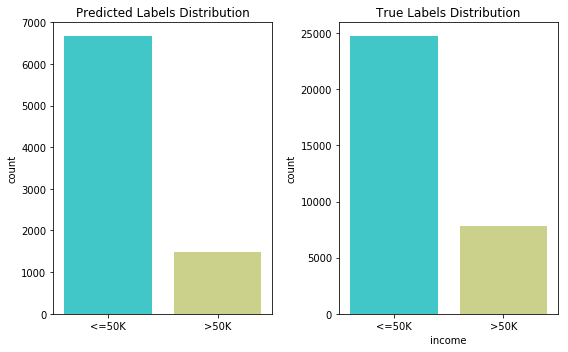

In [394]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(8, 5))

sns.countplot(pd.Series(egregious_model.predict(X3_test)).replace({0: '<=50K', 1: '>50K'}), palette='rainbow',  ax=ax)
sns.countplot(raw_census['income'], palette='rainbow',  ax=bx)

ax.set_title("Predicted Labels Distribution")
bx.set_title("True Labels Distribution")

plt.tight_layout()

Text(0.5,1,'Relative Weighting Given To Each Feature Towards Predicting Whether An Individual Makes Above 50K')

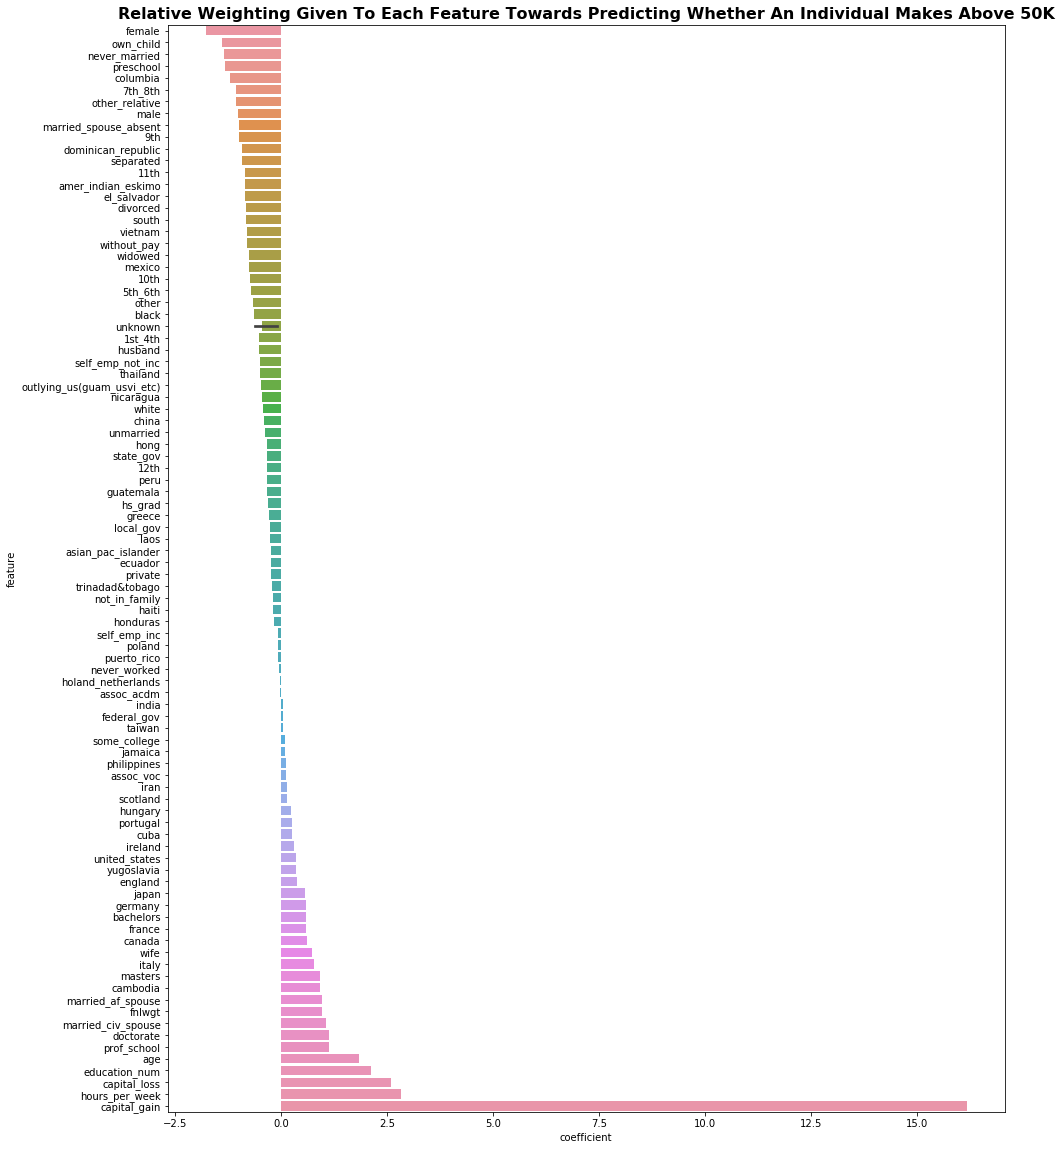

In [467]:
fig, ax = plt.subplots(1,1, figsize=(15,20))

sns.barplot(
    y='feature', 
    x='coefficient', 
    data=pd.DataFrame({'coefficient': egregious_model.coef_[0], 'feature': egregiously_verbose_census.drop(columns='income').columns.values}).sort_values(by='coefficient'),
    ax=ax
)

plt.title("Relative Weighting Given To Each Feature Towards Predicting Whether An Individual Makes Above 50K", fontsize=16, fontweight='bold')

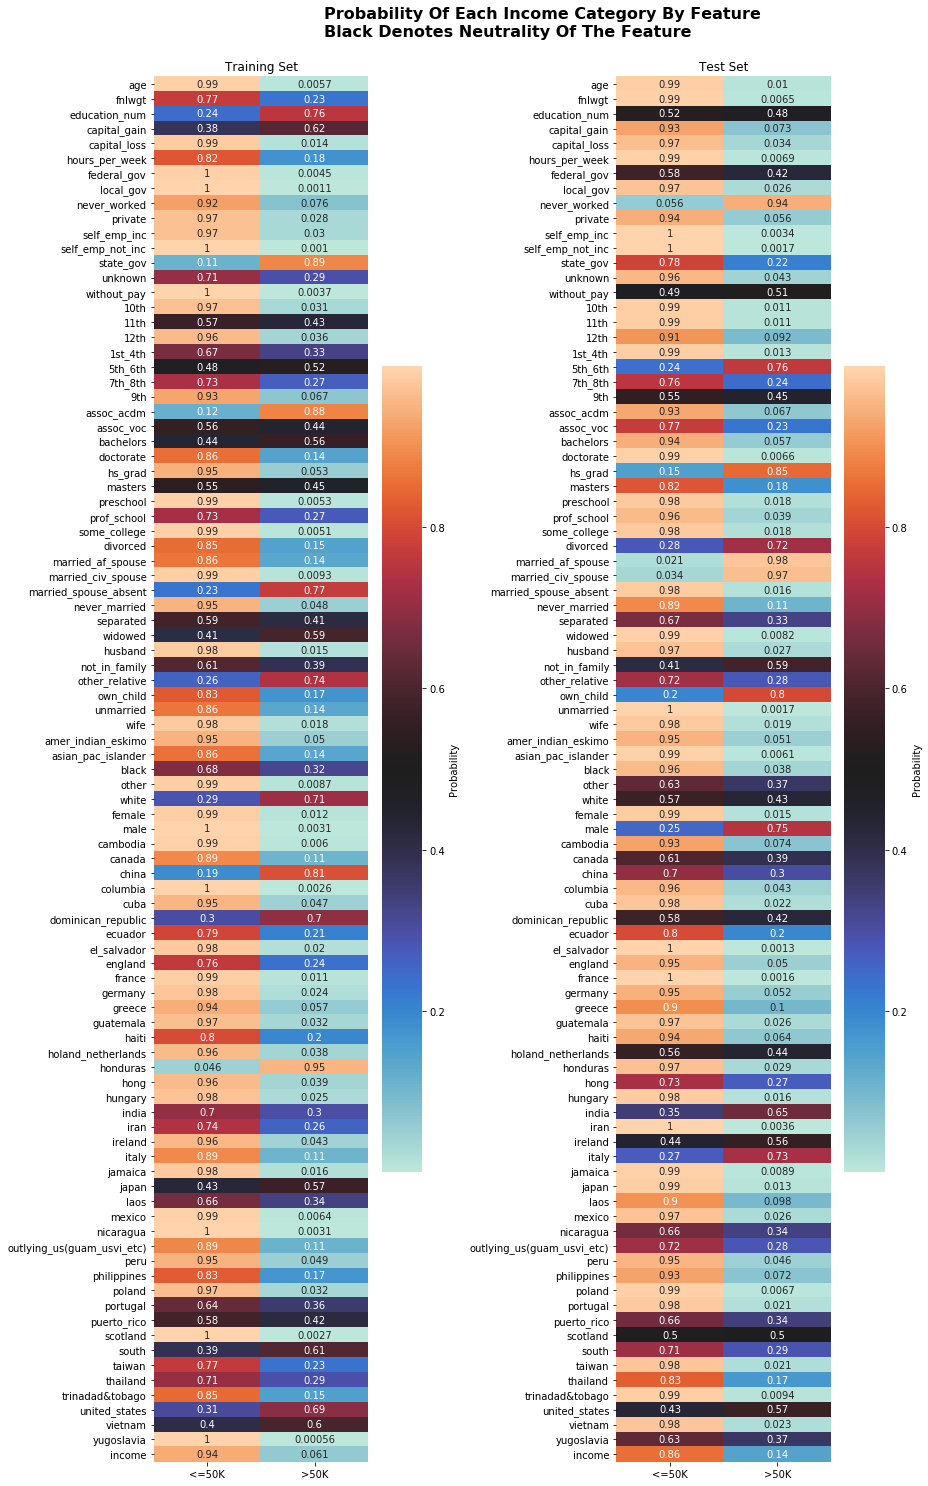

In [466]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(13,20))

sns.heatmap(
    pd.DataFrame(
        {column: probabilities for column, probabilities in zip(egregiously_verbose_census.columns.values, egregious_model.predict_proba(X3_train))}, 
        index=y3.replace({0: '<=50K', 1: '>50K'}).unique()
    ).T,
    cbar_kws={'label': 'Probability'},
    center=.5,
    annot=True,
    ax=ax
)

sns.heatmap(
    pd.DataFrame(
        {column: probabilities for column, probabilities in zip(egregiously_verbose_census.columns.values, egregious_model.predict_proba(X3_test))}, 
        index=y3.replace({0: '<=50K', 1: '>50K'}).unique()
    ).T,
    cbar_kws={'label': 'Probability'},
    center=.5,
    annot=True,
    ax=bx
)

ax.set_title("Training Set")
bx.set_title("Test Set")

fig.suptitle("Probability Of Each Income Category By Feature\nBlack Denotes Neutrality Of The Feature", fontweight='bold', fontsize=16,  x=0.35, y=1.03, horizontalalignment='left', verticalalignment='top')

plt.tight_layout()

In [435]:
# The average individual in all respects has a more likely chance than not of having an income below 50k
egregious_model.predict_proba([egregiously_verbose_census.drop(columns='income').mean()])

array([[ 0.88306068,  0.11693932]])

## Part 3 - Analysis, Interpretation, and Questions

### Based on your above model, answer the following questions

1. What are 3 features positively correlated with income above 50k?
2. What are 3 features negatively correlated with income above 50k?
3. Overall, how well does the model explain the data and what insights do you derive from it?

*These answers count* - that is, make sure to spend some time on them, connecting to your analysis above. There is no single right answer, but as long as you support your reasoning with evidence you are on the right track.

Note - scikit-learn logistic regression does *not* automatically perform a hypothesis test on coefficients. That is OK - if you scale the data they are more comparable in weight.

### Match the following situation descriptions with the model most appropriate to addressing them

In addition to logistic regression, a number of other approaches were covered this week. Pair them with the situations they are most appropriate for, and briefly explain why.

Situations:
1. You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.
2. You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.
3. You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.

Approaches:
1. Ridge Regression
2. Quantile Regression
3. Survival Analysis

### Responses

- The most predictive features of making greate than 50k are `capital_gain`, `hours_per_week`, and `capital_loss`. I suppose the last feature makes sense, in that you have to have
  money to lost it.
  
- The features which anti-correlate with having an income over 50K are `female`, `own_child`, and `never_married`. This makes sense given the historical discrimination and societal
  burdens put on the set of individuals who exist at the intersection of those three features.
  
- Overall, the model is moderate to pretty good, though prehaps not effective at classifying individuals according to whether they make more or less than 50k. As you can see
  in the differences in MSE above, and in the probability plots, the model is somewhat overfit. I would not have guesss before hand that being married to someone, or being in,
  the military would be such a great predictor of having an income greate than 50K. And, while it's obvious in hindsight, I wouldn't have outright guessed that the capital gains
  feature would correlate so highly. I do think that some of the insights are spurious, and prone to misinterpretation, if not paired with the bar plot of the weights above,
  for example according to the probability plot, the feature `never_worked` has a 94% probability of being classified as having an income greater than 50k. Now, this could
  be true due to outliers of individuals who thrive off of trust funds, but if you're predicting for the average individual, this would be highly misleading. In fact, it would
  make for a great use of Quantile Regression.

1. Quantile Regression would be the most appropriate method here. The distribution of grades is notoriously skewed, hence this style of regression would allow you to fit 
   to the quantile past which students receive bad grades based on some set of features.

2. Survival Analysis would be the most appropriate model. The fact that we're predicting an event makes this a killer application of survival analysis.

3. Ridge regression would be the most appropriate model. Because this problem is ill-poised, using some form of tikhonov regularization would allow us to model the
   data appropriately given the constraints at hand.